Populating the interactive namespace from numpy and matplotlib
Traceback (most recent call last):
  File "/home/liamk/Projects/geospacepy-lite/geospacepy/__init__.py", line 8, in <module>
    from geospacepy.geospacepy_config import config
ModuleNotFoundError: No module named 'geospacepy.geospacepy_config'

Solar wind data files will be saved to /home/liamk/.local/share/geospacepy


IntText(value=2010, description='Year')

IntText(value=5, description='Month')

IntText(value=29, description='Day')

IntText(value=12, description='Hour')

IntText(value=0, description='Minute')

Dropdown(description='Type of Aurora', options=('diff', 'mono', 'wave', 'ions'), value='diff')

Dropdown(description='Type of Flux', options=('energy', 'number', 'average energy'), value='energy')

ToggleButton(value=False, description='Correction')

ToggleButton(value=True, description='Combine N&S')

FloatText(value=-1.0, description='Newell Coupling (-1 to use date)')

FloatText(value=-1.0, description='Colorbar Min (-1 is Autoscale)')

FloatText(value=-1.0, description='Colorbar Max (-1 is Autoscale)')

Button(description='Calculate', style=ButtonStyle())

Created new solar wind interval: 2010-05-28 00:00:00-2010-05-31 00:00:00
Created new solar wind interval: 2010-05-28 00:00:00-2010-05-31 00:00:00
Using cached solar wind interval: 2010-05-28 00:00:00-2010-05-31 00:00:00
Using cached solar wind interval: 2010-05-28 00:00:00-2010-05-31 00:00:00


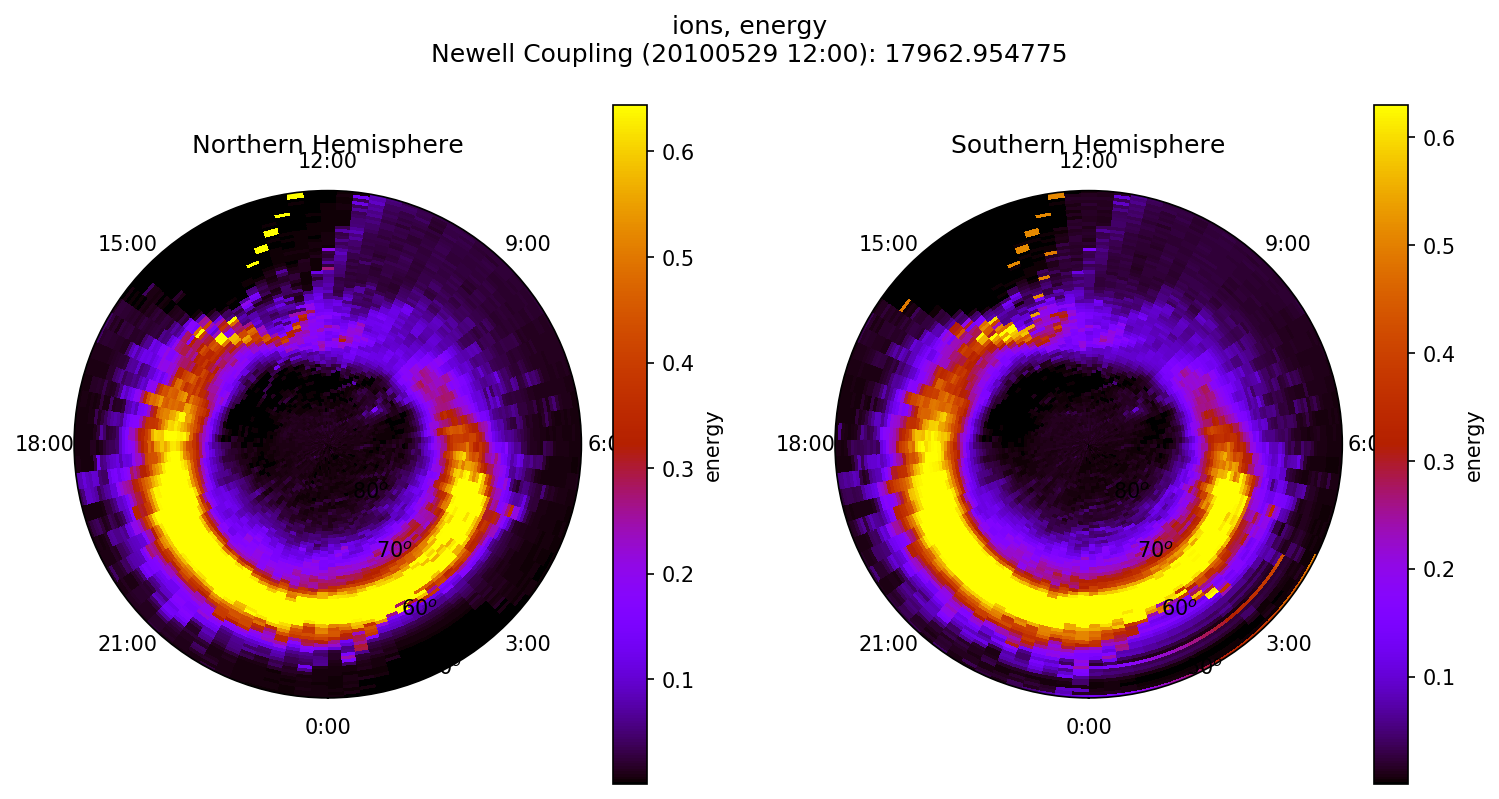

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
import ipywidgets
from collections import OrderedDict
from functools import partial

auroral_types = ['diff','mono','wave','ions']
flux_types = [
                "energy",
                "number",
                "average energy"
            ]

def plot_date_fluxes_callback(clicked_button,widgets):
    f = plt.figure(figsize=(12,6),dpi=150)
    axN = f.add_subplot(121,projection='polar')
    axS = f.add_subplot(122,projection='polar')
    atype = widgets['atype_select'].value
    jtype = widgets['jtype_select'].value
    bincorrect = widgets['bincorrect_toggle'].value
    combine_hemispheres = widgets['combineNS_toggle'].value
    manual_newell = widgets['newell_float'].value
    year = widgets['year'].value
    month = widgets['month'].value
    day = widgets['day'].value
    hour = widgets['hour'].value
    minute = widgets['minute'].value
    dt = datetime.datetime(year,month,day,hour,minute)
    dtstr = dt.strftime('%Y%m%d %H:%M')
    if jtype=='average energy':
        estimator = AverageEnergyEstimator(atype)
        get_precip_for_time = estimator.get_eavg_for_time
    else:
        estimator = FluxEstimator(atype,jtype)
        get_precip_for_time = estimator.get_flux_for_time
        
    if manual_newell != -1.:
        estimator._dF = manual_newell
    tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                    'return_dF':True}
    fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
    mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
    fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
    mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS
    if bincorrect:
        bcN = BinCorrector(mlatgridN,mltgridN)
        fluxgridN = bcN.fix(fluxgridN)
        bcS = BinCorrector(mlatgridS,mltgridS)
        fluxgridS = bcS.fix(fluxgridS)
        print("Correction Applied")
    pcolor_kwargs = {'cmap':'gnuplot'}
    manual_vmin = wgts['vmin_float'].value
    if manual_vmin != -1.:
        pcolor_kwargs['vmin']=manual_vmin
    manual_vmax = wgts['vmax_float'].value
    if manual_vmax != -1.:
        pcolor_kwargs['vmax']=manual_vmax
    mappableN = pcolor_flux(axN,mlatgridN,mltgridN,fluxgridN,'N',**pcolor_kwargs)
    mappableS = pcolor_flux(axS,mlatgridS,mltgridS,fluxgridS,'S',**pcolor_kwargs)
    f.colorbar(mappableN,ax=axN,label=jtype)
    f.colorbar(mappableS,ax=axS,label=jtype)
    axN.set_title('Northern Hemisphere')
    axS.set_title('Southern Hemisphere')
    polar2dial(axN)
    polar2dial(axS)
    f.suptitle(('%s, %s' % (atype,jtype)
                +'\nNewell Coupling (%s): %f' % (dtstr,newell_coupling)))
    plt.show()
    

wgts = OrderedDict()
wgts['year']=ipywidgets.IntText(description='Year',value=2010)
wgts['month']=ipywidgets.IntText(description='Month',value=5)
wgts['day']=ipywidgets.IntText(description='Day',value=29)
wgts['hour']=ipywidgets.IntText(description='Hour',value=12)
wgts['minute']=ipywidgets.IntText(description='Minute',value=0)
wgts['atype_select']=ipywidgets.Dropdown(options=auroral_types,description='Type of Aurora')
wgts['jtype_select']=ipywidgets.Dropdown(options=flux_types,description='Type of Flux')
wgts['bincorrect_toggle']=ipywidgets.ToggleButton(description='Correction',value=False)
wgts['combineNS_toggle']=ipywidgets.ToggleButton(description='Combine N&S',value=True)
wgts['newell_float']=ipywidgets.FloatText(description='Newell Coupling (-1 to use date)',value=-1)
wgts['vmin_float']=ipywidgets.FloatText(description='Colorbar Min (-1 is Autoscale)',value=-1)
wgts['vmax_float']=ipywidgets.FloatText(description='Colorbar Max (-1 is Autoscale)',value=-1)
wgts['run_button'] = ipywidgets.Button(description='Calculate')
wgts['run_button'].on_click(partial(plot_date_fluxes_callback,widgets=wgts))

for widget_name,widget in wgts.items():
    display(widget)